# Clustering Mall Customers in Python

## Introduction

This notebook presents a **Cluster Analysis** project in Python focused on the well-known **"Mall Customers" dataset** available on [Kaggle](https://www.kaggle.com/datasets/shwetabh123/mall-customers)

This project is part of a 3-part series published on [Towards AI](https://towardsai.net/). 
For detailed theoretical explanations and business context, please refer to the articles:  

- [Part 1](https://medium.com/towards-artificial-intelligence/the-outlier-and-feature-selection-dilemma-preparing-data-for-clustering-ebf228b5810c) : Exploratory Data Analysis, handling outliers, and feature selection using Mutual Information;
- [Part 2](https://medium.com/towards-artificial-intelligence/3-algorithms-and-4-configurations-for-customer-segmentation-4a6b244bb3c1): Identifying optimal parameters for K-Means, GMM, and Linkage methods;
- [Part 3](https://medium.com/towards-artificial-intelligence/from-math-to-marketing-validating-clusters-and-extracting-actionable-insights-264d4443ee3b): Validation, Selection, and Visualization: Evaluating metrics and extracting actionable business insights-- 






Notebook structure:

**1. EDA, outliers and feature selection**  
**2. K-Means, Agglomerative Clustering and GMM: Looking for the Best Configuration**  
**3. Clustering Validation: assessing the quality and consistency of the identified models**  
**4. Final Evaluation and Business Insights**

### EDA, outliers and feature selection

#### Importing Libraries and Loading Data

In [1]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
# Load Data
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
# Check for missing values
print("Missing Values\n")
print(df.isna().sum())

# Check for duplicated rows
print("\nDuplicated Rows\n")
print(df.duplicated().sum())

Missing Values

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicated Rows

0


In [6]:
# Remove unnecessary CustomerID column
df_features= df.copy()
df_features.drop(["CustomerID"],axis=1,inplace=True)

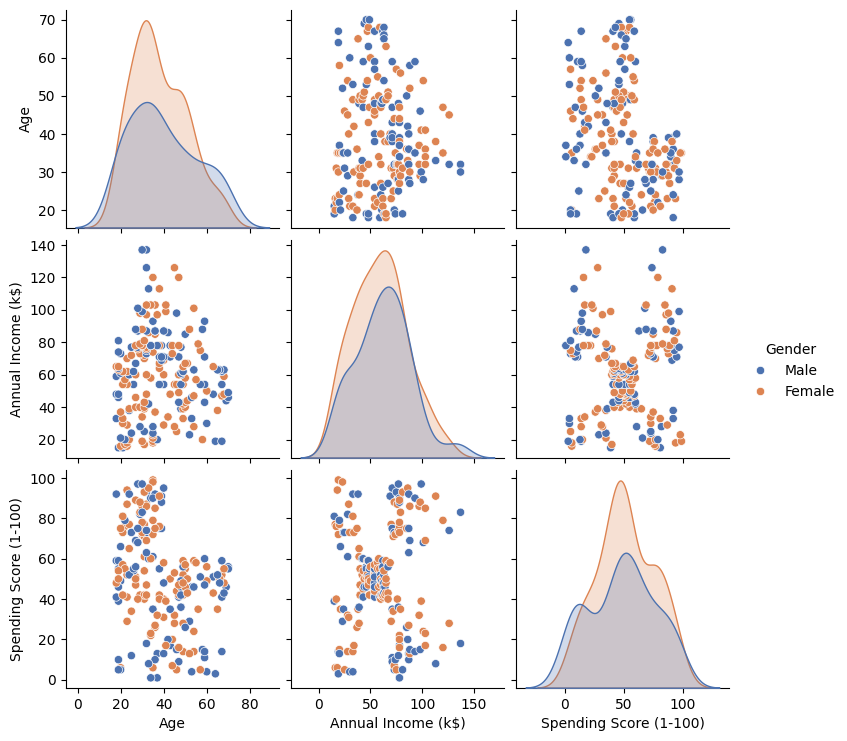

In [7]:
# Plot pairwise relationships in the dataset
custom_palette = {'Male': '#4C72B0', 'Female': '#DD8452'}
sns.pairplot(df_features,hue='Gender',palette=custom_palette)
plt.show()

**Key insights:**  

**Spending Score vs Annual Income (Row 3, Column 2)**  
The most structured plot, revealing 5 clear potential clusters. This suggests $K=5$ as a strong candidate for K-Means.

**Spending Score vs Age (Row 3, Column 1)**  
High spending scores are notably concentrated among younger customers. Age appears to be a significant factor for isolating high-value segments.

**The role of Gender (Color: Orange = Female, Blue = Male)**  
No significant separation between Male/Female is visible across most distributions, suggesting Gender may be noise for the clustering process.

#### Outlier Detection and Handling

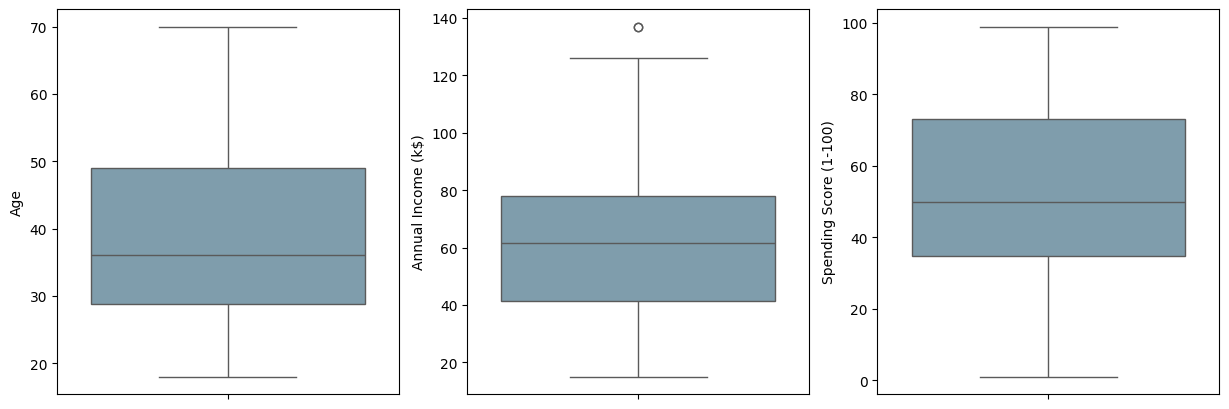

In [8]:
# Visualizing data distribution and potential outliers using boxplots
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
sns.boxplot(y=df_features['Age'], ax=axes[0],color="#789fb3")
sns.boxplot(y=df_features['Annual Income (k$)'], ax=axes[1],color="#789fb3")
sns.boxplot(y=df_features['Spending Score (1-100)'], ax=axes[2],color="#789fb3")
plt.show()


As shown in the box plots, there is only one visible outlier in the 'Annual Income (k$)' column. We will now apply the Interquartile Range (IQR) method to determine the exact number of outliers, as the visual representation may hide multiple overlapping data points.

In [9]:
# Evaluation of the first and third quartile
Q1 = np.percentile(df_features['Annual Income (k$)'], 25, method='midpoint')
Q3 = np.percentile(df_features['Annual Income (k$)'], 75, method='midpoint')
# IQR is calculated as the difference between Q3 and Q1
IQR = Q3 - Q1
# Upper bound: Q3+1.5∗IQR
upper_bound = Q3 + 1.5 * IQR
# Outlier Count
outlier = df_features[(df_features['Annual Income (k$)'] >= upper_bound)]
print(f"Number of Outlier for the column Annual Income (k$): {len(outlier)}")  


Number of Outlier for the column Annual Income (k$): 2


In [10]:
# Outlier removal: filter the dataframe to keep only records within the upper bound
upper_array = np.where(df_features['Annual Income (k$)'] >= upper_bound)[0]
df_features_no_outliers=df_features.drop(index=upper_array)
# Result verification
print("Old Shape: ", df_features.shape)
print("New Shape: ", df_features_no_outliers.shape)

Old Shape:  (200, 4)
New Shape:  (198, 4)


#### Feature Selection via Mutual Information

In [11]:
# Label encoding for Gender
df_features['Gender'], _ = df_features['Gender'].factorize()
df_features_no_outliers['Gender'], _ = df_features_no_outliers['Gender'].factorize()

In [12]:
#The function `make_mi_scores` treats each feature as a target and calculates its relationship with all other variables. 
# By summing these scores, we measure the "centrality" of a feature. A high cumulative MI indicates 
# a variable that shares significant information with the rest of the system, making it essential for defining stable clusters.
def make_mi_scores(df_input):
    # Initialize dictionary to store the total MI (centrality) for each feature
    result = {}
    for col in df_input:
        # Define 'col' as target (y) and all other columns as predictors (X)
        X = df_input.copy()
        y = X.pop(col)
        # Create a boolean mask for discrete predictors remaining in X
        is_discrete = (X.columns == 'Gender')
        # Use classification MI for categorical target (Gender), 
        # regression MI for continuous targets (Age, Income, Spending Score)
        if col=='Gender':
            mi_scores = mutual_info_classif(X, y, discrete_features=is_discrete, random_state=42)
        else:        
            mi_scores = mutual_info_regression(X, y, discrete_features=is_discrete, random_state=42)
        result[col]=sum(mi_scores)
    return result

mi_scores = make_mi_scores(df_features)
mi_scores_no_outliers = make_mi_scores(df_features_no_outliers)

In [13]:
# Convert dictionaries to DataFrames for easier manipulation and sorting
scores_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=['MI Score'])
scores_df_no_outliers = pd.DataFrame.from_dict(mi_scores_no_outliers, orient='index', columns=['MI Score'])
# Sort scores in descending order to highlight the most influential features
scores_df = scores_df.sort_values(by="MI Score", ascending=False)
scores_df_no_outliers = scores_df_no_outliers.sort_values(by="MI Score", ascending=False)
# Merge the two results into a single table
score_union = pd.concat([scores_df, scores_df_no_outliers], axis=1)
# Rename columns
score_union.columns = ['With Outliers', 'Without Outliers']
# Apply a color gradient
score_union.style.background_gradient(cmap='YlGnBu')

,With Outliers,Without Outliers
Spending Score (1-100),0.793983,0.785338
Annual Income (k$),0.626657,0.625169
Age,0.512832,0.560422
Gender,0.089650,0.094172


**Dominant Features**: The Spending Score remains the primary driver for our clusters ($MI \approx 0.79$).  
**Income Stability**: Annual Income shows remarkable stability ($0.627 \rightarrow 0.625$), confirming its relationship with other features is robust.  
**Age Dynamics**: Age benefited most from cleaning ($0.513 \rightarrow 0.560$), though its importance ranking remains unchanged.  
**Gender**: In both datasets, Gender shows an extremely low MI score (below 0.10). This statistically confirms that including it would likely add noise rather than value.

#### Dataset Configurations for Model Evaluation

Based on the previous Mutual Information and Pairplot analyses, the most promising configuration appears to be the subset including Spending Score and Annual Income using the complete dataset: the impact of outliers can be considered negligible.

For educational and comparative purposes, we will not limit our study to a single scenario. Instead, we will evaluate our clustering algorithms across four different dataset configurations:
- **2D Scenario** (Annual Income, Spending Score): tested both with and without outliers.
- **3D Scenario** (Age, Annual Income, Spending Score): tested both with and without outliers.
  
This multi-scenario approach allows us to empirically observe how the inclusion of specific features or the presence of outliers affects the performance, shape, and stability of the resulting clusters.


#### Feature Scaling: StandardScaler  

In [14]:
std_scaler = StandardScaler()
# 2D Scenario: Annual Income and Spending Score 
# Original dataset
X_IncomeSpending_all = std_scaler.fit_transform(df_features.loc[:, [ 'Annual Income (k$)', 'Spending Score (1-100)']].values)
# Dataset without ouliers
X_IncomeSpending_no_outliers = std_scaler.fit_transform(df_features_no_outliers.loc[:, [ 'Annual Income (k$)', 'Spending Score (1-100)']].values)
# 3D Scenario: Age, Annual Income and Spending Score 
# Original dataset
X_AgeIncomeSpending_all = std_scaler.fit_transform(df_features.loc[:, ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values)
# Dataset without ouliers
X_AgeIncomeSpending_no_outliers = std_scaler.fit_transform(df_features_no_outliers.loc[:, ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values)

### K-Means, Agglomerative Clustering and GMM: Looking for the Best Configuration

#### K-Means Clustering
**Finding the Optimal K** using the Elbow Method.

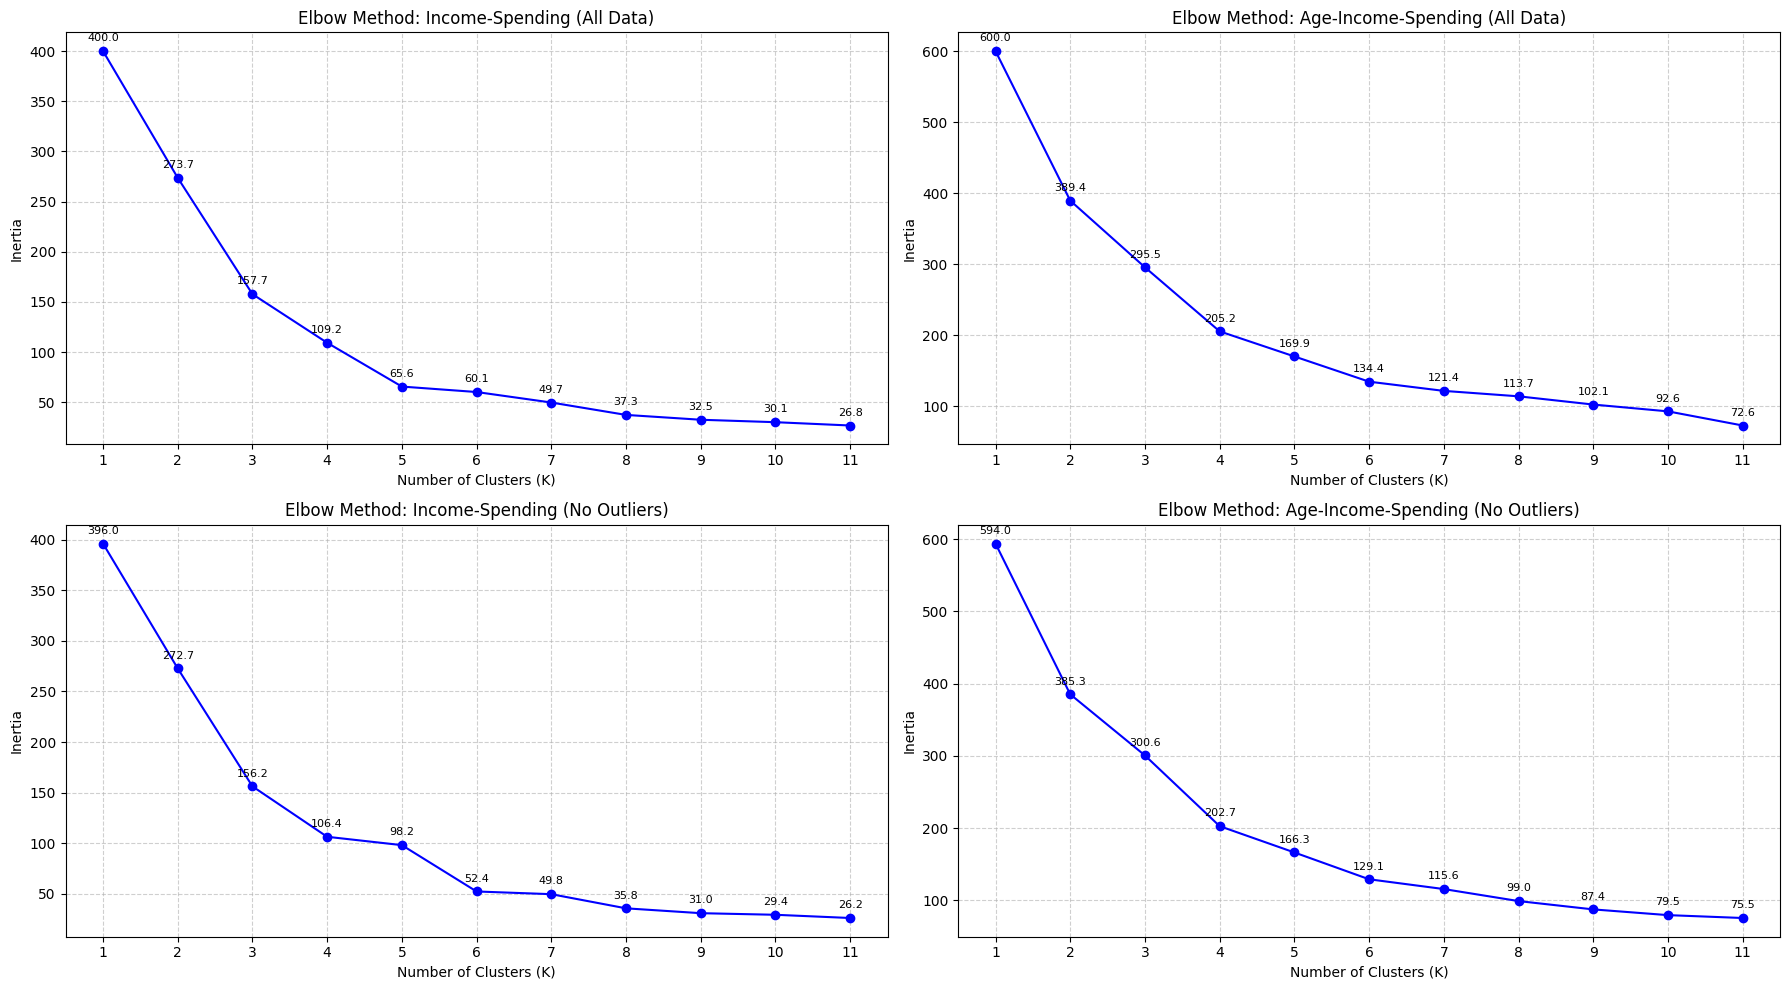

In [15]:
# Define the range of K (number of clusters) to test
K_range = range(1, 12) 
# Define variables that we use in the algorithms 
dataset_configurations = [
    {'dataset': X_IncomeSpending_all,'label': 'Income-Spending (All Data)'},
    {'dataset': X_AgeIncomeSpending_all,'label': 'Age-Income-Spending (All Data)'},
    {'dataset': X_IncomeSpending_no_outliers,'label': 'Income-Spending (No Outliers)'},
    {'dataset': X_AgeIncomeSpending_no_outliers,'label': 'Age-Income-Spending (No Outliers)'}
]
# Evaluation: Run the clustering process for each dataset configuration
results = {}
for dc in dataset_configurations:
    data_label = dc['label']
    data_set = dc['dataset']
    # Calculate inertia for each k in the range
    inertias = [KMeans(n_clusters=k, init='k-means++', n_init='auto', random_state=42).fit(data_set).inertia_ for k in K_range]
    k_mapping = dict(zip(K_range, inertias))   
    results[data_label] = {'inertias': inertias, 'k_mapping': k_mapping}
# Visualize the Elbow Method results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10)) 
axes = axes.flatten() 
labels = list(results.keys())
for i, ax in enumerate(axes):
    label = labels[i]
    inertias = results[label]['inertias']    
    # Plotting the elbow curve
    ax.plot(K_range, inertias, marker='o', linestyle='-', color='b') 
    # Adding text annotations for each inertia value
    for k, val in zip(K_range, inertias):
        ax.annotate(f'{val:.1f}', xy=(k, val), xytext=(0, 7), textcoords='offset points', ha='center', fontsize=8)
    ax.set_title(f"Elbow Method: {label}", fontsize=12)
    ax.set_xlabel("Number of Clusters (K)", fontsize=10)
    # Set Y-axis label for the leftmost plots in each row
    ax.set_ylabel("Inertia", fontsize=10)        
    ax.set_xticks(K_range)
    ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
plt.show()

#### Elbow Method Analysis Findings

- **Income & Spending (2D)** - Graphs on the left: In the complete dataset, a clear elbow appears at K=5. However, when outliers are removed, we observe a significant secondary drop in inertia between K=5 and K=6.
- **Age, Income & Spending (3D)** - Graphs on the right: A slight bend is visible at K=6.

**Impact of Outliers**: Across both feature sets, the "No Outliers" plots exhibit lower overall inertia. 

#### Candidate Selection for Validation
We will carry forward the following settings for the validation phase:
- 2D Features: K=5 (Original dataset) and K=6 (No outliers dataset); 
- 3D Features: K= 6 (both Original & No outliers dataset).  

#### Agglomerative Clustering
**Finding the Optimal K** by observing dendrograms.

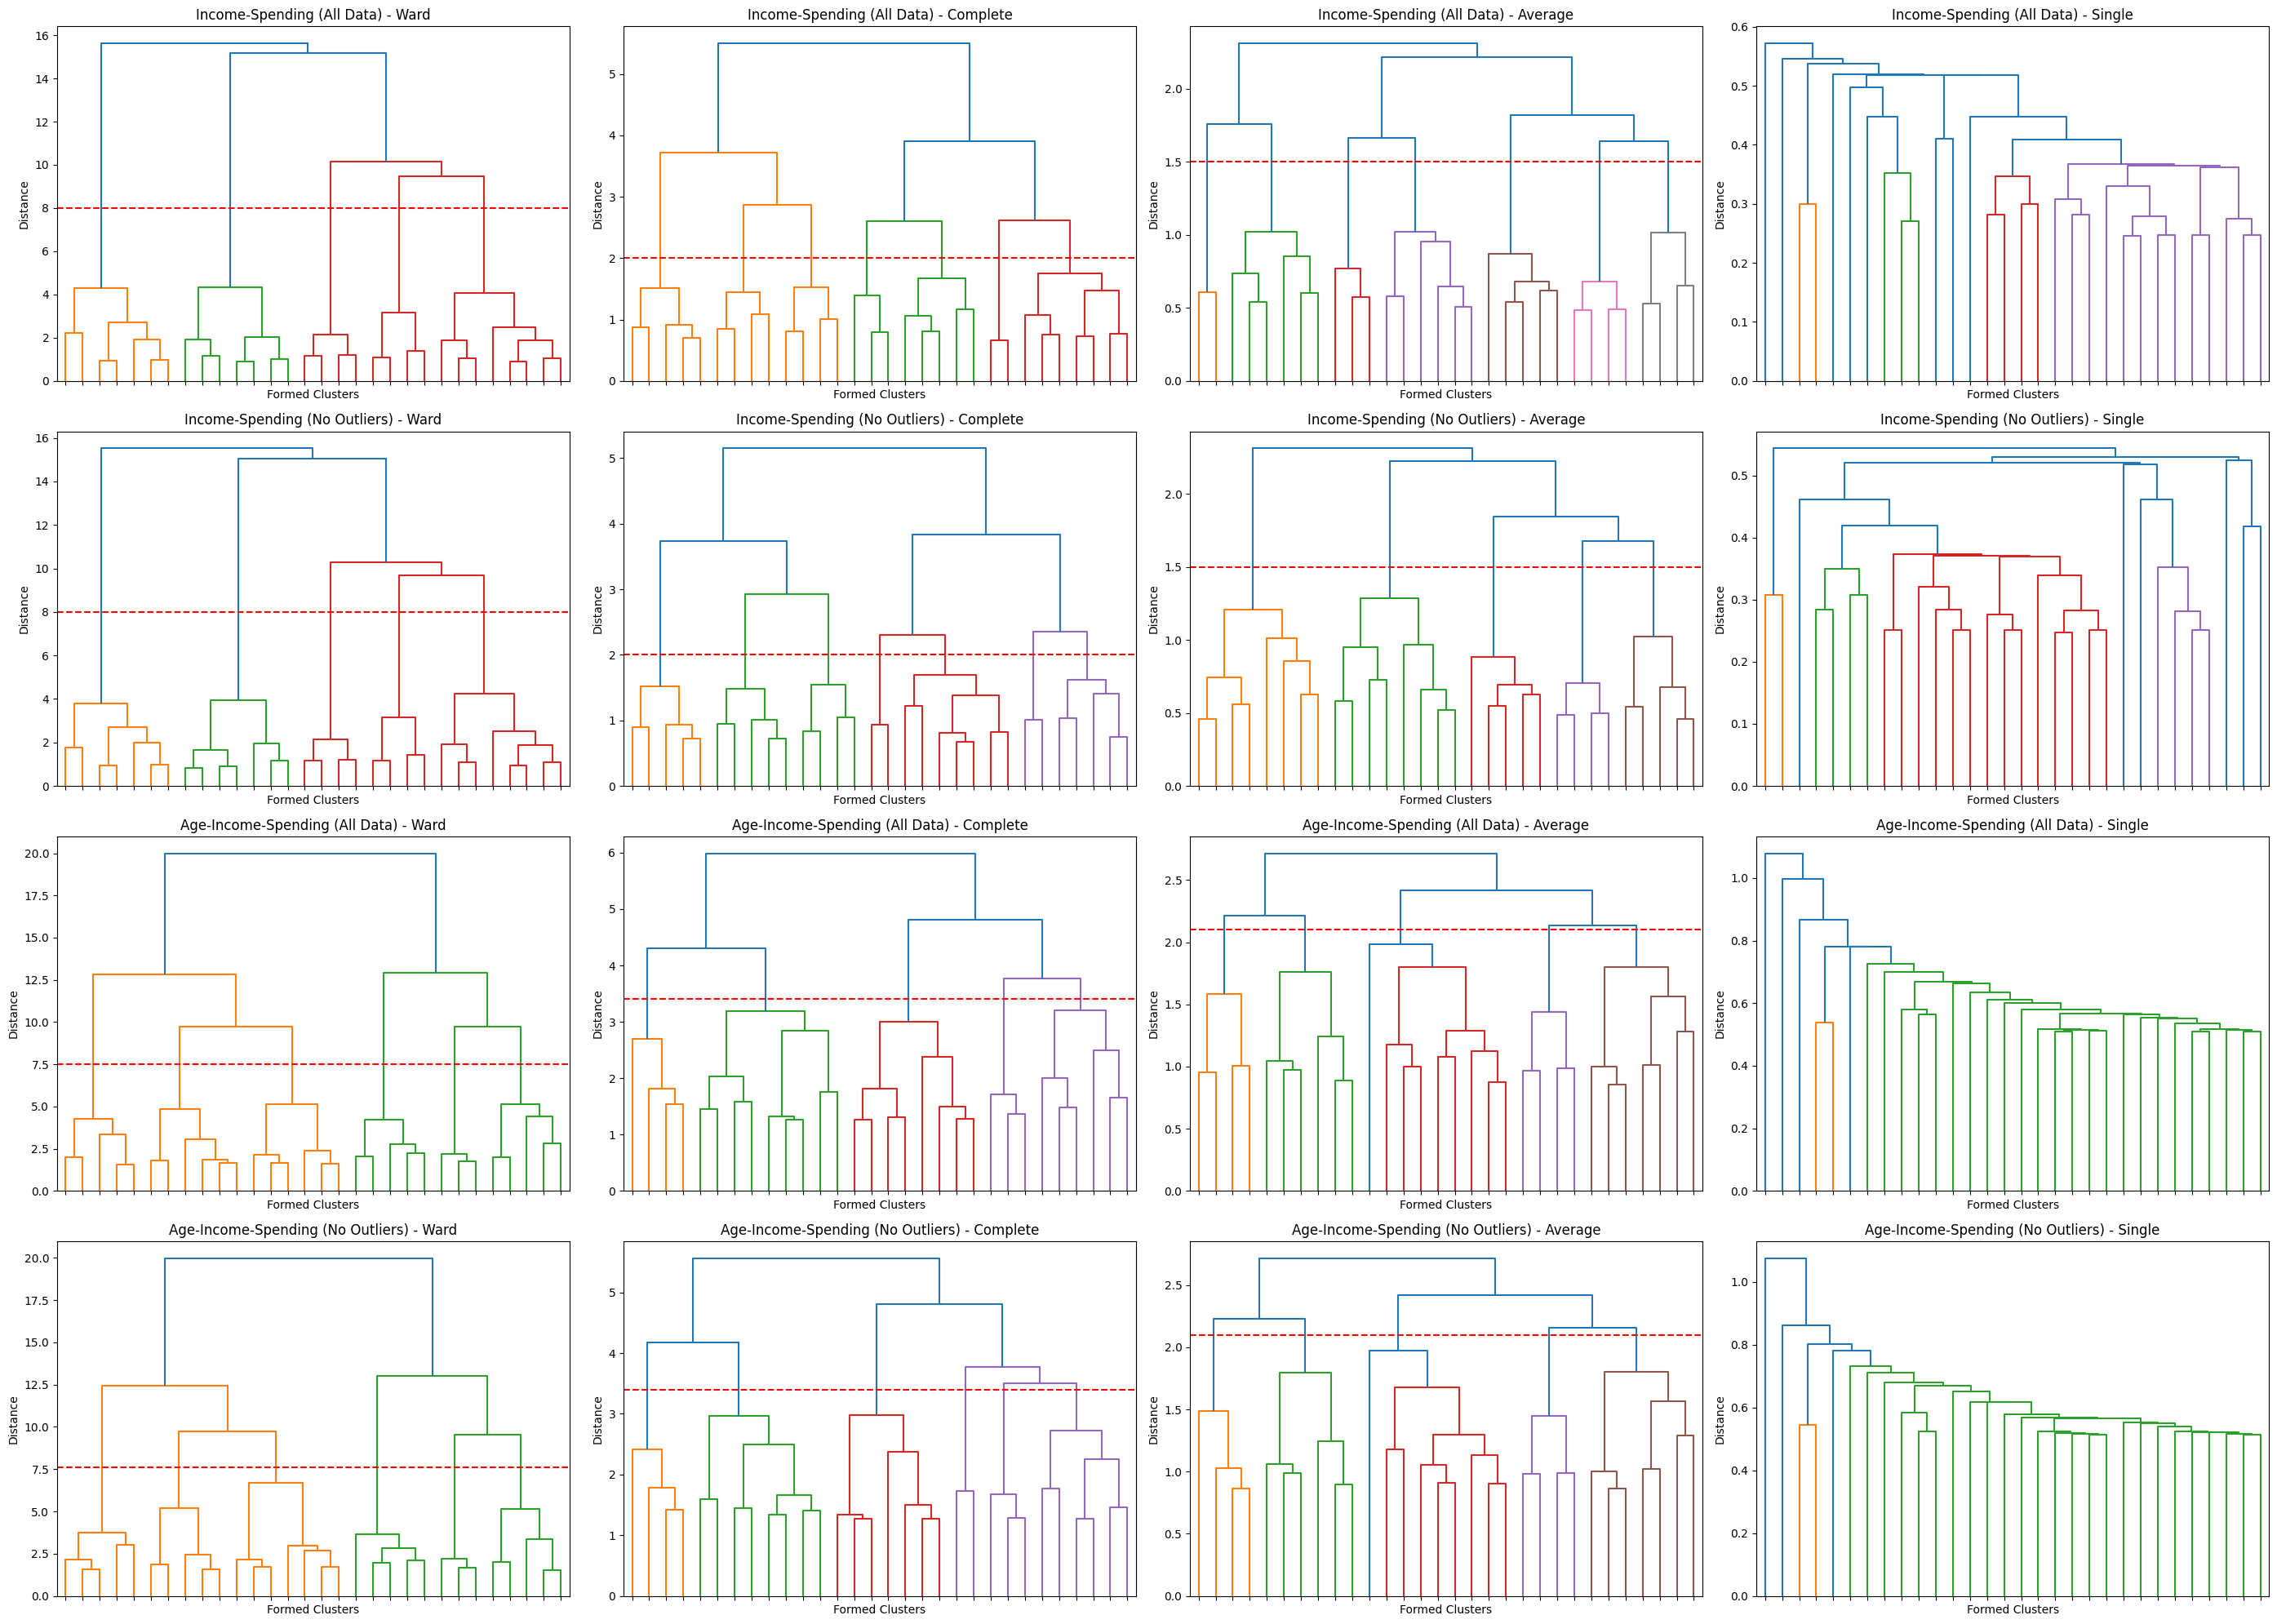

In [16]:
# Define list for the linkage methods
LINKAGE_METHODS = ['ward', 'complete', 'average', 'single']
# Define variables that we use in the algorithms 
dataset_configurations = [
    {'dataset': X_IncomeSpending_all, 'label': 'Income-Spending (All Data)', 'heights': [8, 2, 1.5]},
    {'dataset': X_IncomeSpending_no_outliers, 'label': 'Income-Spending (No Outliers)', 'heights': [8, 2, 1.5]},
    {'dataset': X_AgeIncomeSpending_all, 'label': 'Age-Income-Spending (All Data)', 'heights': [7.5, 3.4, 2.1]},
    {'dataset': X_AgeIncomeSpending_no_outliers, 'label': 'Age-Income-Spending (No Outliers)', 'heights': [7.6, 3.4, 2.1]}
]
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(28, 20))
# Outer Loop: Iterates over Dataset Configurations
for row_idx, dc in enumerate(dataset_configurations):
    data_set = dc['dataset']
    data_label = dc['label']
    # Inner Loop: Iterates over Linkage Methods
    for col_idx, method in enumerate(LINKAGE_METHODS):
        # Linkage matrix
        Z = linkage(data_set, method=method)
        # Dendrogram generation
        ax_dendro = axes[row_idx, col_idx]
        dendrogram(Z, truncate_mode='lastp', ax=ax_dendro)
        # Add a horizontal threshold line 
        if 'heights' in dc and col_idx < len(dc['heights']):
            h = dc['heights'][col_idx]
            ax_dendro.axhline(y=h, color='r', linestyle='--', linewidth=1.5)
        title = f'{data_label} - {method.capitalize()}'
        ax_dendro.set_title(title, fontsize=12)
        ax_dendro.set_xlabel('Formed Clusters', fontsize=10)
        ax_dendro.set_ylabel('Distance', fontsize=10) 
        ax_dendro.tick_params(axis='x', which='both', bottom=True, labelbottom=False)

fig.tight_layout()
plt.show()

#### Dendrograms Findings
1. **Income-Spending (2D) - Rows 1 & 2**  
   **Ward's Method:** At $h=8.0$, this method produces distinct and compact clusters. Comparing "All Data" to "No Outliers," it is evident that outliers do not influence cluster stability;  
   **Complete Method**: A cut at $h \approx 2$ yields 7 clusters. In this case as well, the presence of outliers does not alter the overall structure; 
   **Average Method:** The cut at $h \approx 1.5$ highlights the impact of data cleaning; removing outliers reveals 5 clusters instead of 7, suggesting that this method is more sensitive to extreme values;  
   **Single Method:** Exhibits a clear "chaining" effect. Most points merge at very low distance levels, making it unsuitable for capturing underlying spherical cluster shapes.

2. **Age-Income-Spending (3D)  - Rows 3 & 4**  
   **Ward's Method:** Shows high stability at $h=7.5$ across both datasets. It remains the most robust method, maintaining a consistent cluster count regardless of the added dimension or noise;
   **Complete Method:** A cut at $h \approx 3.4$ reveals the impact of outlier removal, which unmasks 6 clusters instead of 5;  
   **Average Method:** At $h \approx 2.1$, this method produces 5 clusters. In this case, the outliers do not change the results;   
   **Single Method**: The chaining effect is again evident, confirming this method is not recommended for this dataset.   

#### Candidate Selection for Validation
We will carry forward the following settings for the validation phase:
- 2D Features: Ward K=5; Complete K=7 for both Original and No outliers dataset; Average K=7 for original and 5 for No outliers dataset;  
- 3D Features: Ward K=6; Average K=5  for both Original and No outliers dataset; Complete K=5 for original and 6 for No outliers dataset.

#### Gaussian Mixture Model (GMM)
To determine the ideal number of clusters and model structure, two primary metrics are used: 
- **Bayesian Information Criterion (BIC)**; 
- **Akaike Information Criterion (AIC)**  

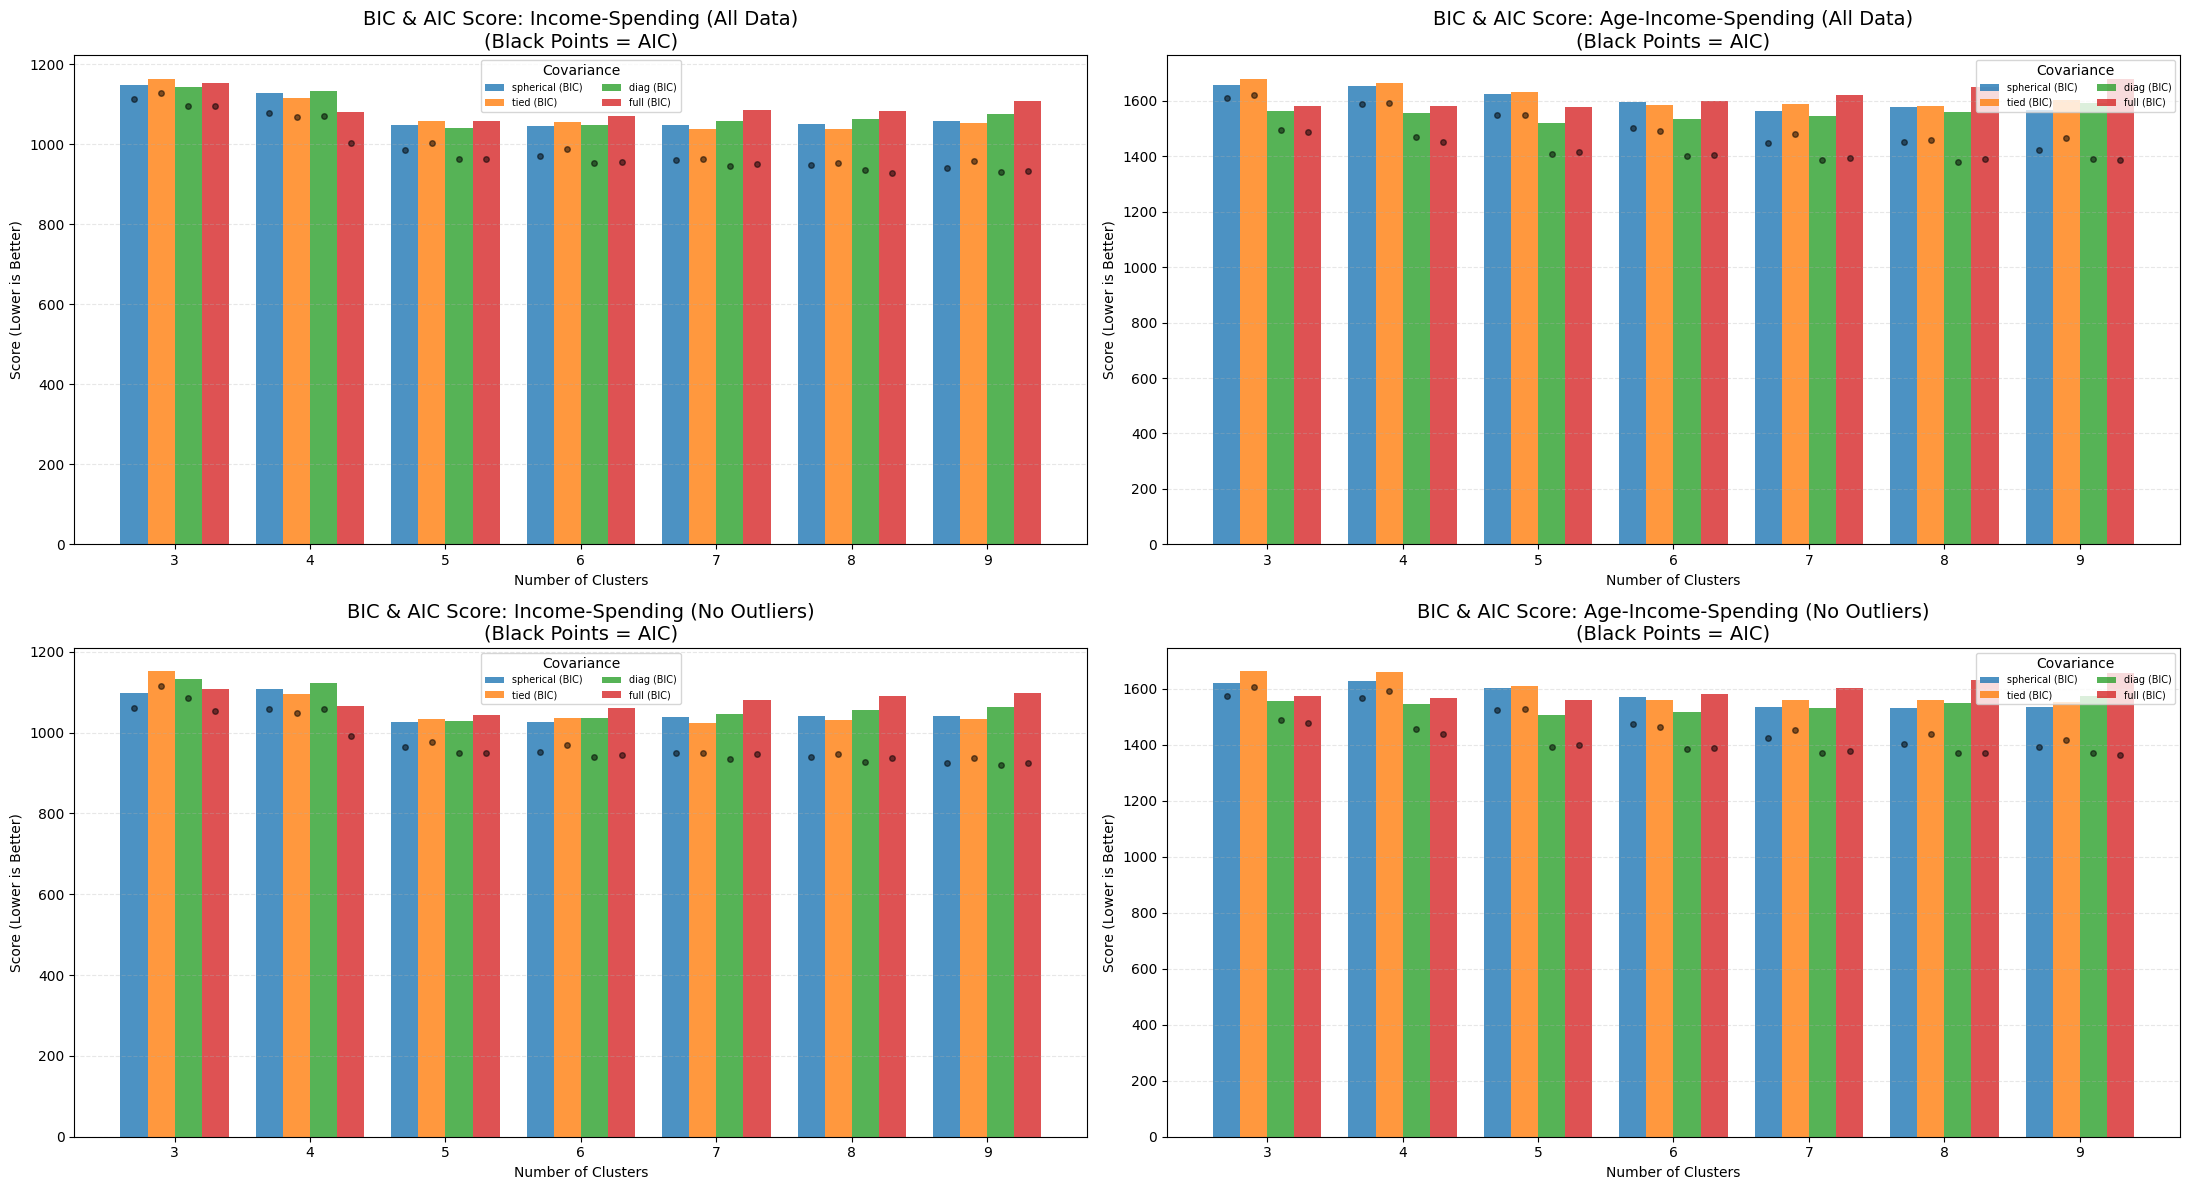

In [17]:
dataset_configurations = [
    {'dataset': X_IncomeSpending_all,'label': 'Income-Spending (All Data)'},
    {'dataset': X_AgeIncomeSpending_all,'label': 'Age-Income-Spending (All Data)'},
    {'dataset': X_IncomeSpending_no_outliers,'label': 'Income-Spending (No Outliers)'},
    {'dataset': X_AgeIncomeSpending_no_outliers,'label': 'Age-Income-Spending (No Outliers)'}
]
# Parameter grid for GMM
param_grid = {
    "n_components": range(3, 10),
    "covariance_type": ["spherical", "tied", "diag", "full"]
}
# GridSearchCV is designed to MAXIMIZE a score. Since the best BIC/AIC is the 
# lowest value, we return the negative value so the algorithm can maximize it.
def gmm_bic_score(estimator, X):
    """Returns the NEGATIVE BIC: allows GridSearchCV to find the minimum by maximizing."""
    return -estimator.bic(X)
def gmm_aic_score(estimator, X):
    """Returns the NEGATIVE AIC: allows GridSearchCV to find the minimum by maximizing."""
    return -estimator.aic(X)
# Set up a grid to accommodate all onfigurations
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
axes = axes.flatten()
for i, dc in enumerate(dataset_configurations):
    ax = axes[i]
    data_set = dc['dataset']
    # The 'scoring' parameter uses our negative function to correctly rank the models.
    grid_search = GridSearchCV(GaussianMixture(random_state=42, n_init=5), param_grid=param_grid, scoring=gmm_bic_score,
        #Determines the cross-validation splitting strategy: we use identical indices to force calculation on the full dataset                      
        cv=[(np.arange(len(data_set)), np.arange(len(data_set)))]
    )
    grid_search.fit(data_set)
    # Process results
    results = []
    # Loop through the grid results (which are currently stored as negative scores)
    for params, score in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
        # To display real (positive) AIC and BIC values, we fit the model briefly.
        # This is necessary because GridSearchCV only stores the primary 'scoring' metric.
        model = GaussianMixture(**params, random_state=42, n_init=5).fit(data_set)
        results.append({
            **params,'bic': model.bic(data_set),'aic': model.aic(data_set)
        })
    df_result = pd.DataFrame(results)
    cov_types = df_result["covariance_type"].unique()
    n_comps = sorted(df_result["n_components"].unique())
    # Plotting
    x = np.arange(len(n_comps))
    width = 0.2 
    for j, cov in enumerate(cov_types):
        subset = df_result[df_result["covariance_type"] == cov].sort_values("n_components")
        # Plot BIC (Bar)
        ax.bar(x + (j * width), subset["bic"], width, label=f"{cov} (BIC)", alpha=0.8)
        # Plot AIC (Points)
        ax.plot(x + (j * width), subset["aic"], marker='o', linestyle='', markersize=4, color='black', alpha=0.5)
    ax.set_title(f"BIC & AIC Score: {dc['label']}\n(Black Points = AIC)", fontsize=14)
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(n_comps)
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Score (Lower is Better)")
    ax.legend(title="Covariance", fontsize='x-small', ncol=2)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

The BIC analysis reveals a relatively flat profile across the tested range of clusters (K=3 to K=9), and the removal of outliers does not significantly alter this trend. I have selected candidate configurations that balance the lowest AIC/BIC scores with model parsimony to avoid unnecessary complexity.  

#### Candidate Selection for Validation  
We will carry forward the following settings for the validation phase: 
- 2D Features (Income-Spending): K=5 and K=6 using Spherical and Diag covariance types for both versions of the dataset;
- 3D Features (Age-Income-Spending): K=5, K=6, and K=7 using Diag covariance for both versions of the dataset.

### Clustering Validation: assessing the quality and consistency of the identified models.

We will now apply the following metrics to evaluate the effectiveness of each approach:

- **Silhouette Score:**;    
- **Calinski-Harabasz Index**;   
- **Davies-Bouldin Index.**

By balancing these scores, we will determine which algorithm and feature set provide the most meaningful and stable customer segments.

In [18]:
# Define optimal_k_map dictionary based on the conclusions of the previous sections:
optimal_k_map = {
    'Income-Spending (All Data)': 
    {'K-Means': [5],'Ward': [5], 'Complete': [7], 'Average': [7], 
         'GMM': [{'n_components': 5, 'covariance_type': 'spherical'},
                {'n_components': 5, 'covariance_type': 'diag'},
                {'n_components': 6, 'covariance_type': 'spherical'},
                {'n_components': 6, 'covariance_type': 'diag'}]},
    'Income-Spending (No Outliers)': 
    {'K-Means': [6], 'Ward': [5], 'Complete': [7], 'Average': [5],
         'GMM': [{'n_components': 5, 'covariance_type': 'spherical'},
                {'n_components': 5, 'covariance_type': 'diag'},
                {'n_components': 6, 'covariance_type': 'spherical'},
                {'n_components': 6, 'covariance_type': 'diag'}]},
    'Age-Income-Spending (All Data)': 
    {'K-Means': [6], 'Ward': [6], 'Complete': [5], 'Average': [5], 
     'GMM': [{'n_components': 5, 'covariance_type': 'diag'},
            {'n_components': 6, 'covariance_type': 'diag'},
            {'n_components': 7, 'covariance_type': 'diag'}]},
    'Age-Income-Spending (No Outliers)': 
    {'K-Means': [6],'Ward': [6], 'Complete': [6], 'Average': [5],
          'GMM': [{'n_components': 5, 'covariance_type': 'diag'},
            {'n_components': 6, 'covariance_type': 'diag'},
            {'n_components': 7, 'covariance_type': 'diag'}]}
}
# Our dataset configurations
dataset_configurations = [
    {'dataset': X_IncomeSpending_all, 'label': 'Income-Spending (All Data)'},
    {'dataset': X_IncomeSpending_no_outliers, 'label': 'Income-Spending (No Outliers)'},
    {'dataset': X_AgeIncomeSpending_all, 'label': 'Age-Income-Spending (All Data)'},
    {'dataset': X_AgeIncomeSpending_no_outliers, 'label': 'Age-Income-Spending (No Outliers)'}
]
def evaluate_clustering(X, labels):
    """
    Calculate clustering metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin)
    INPUTS:
    - X: The feature matrix (data points).
    - labels: The cluster labels assigned to each data point by the clustering algorithm.
    OUTPUTS (Tuple):
    - n_clusters (int): The number of clusters 
    - n_samples (int): The number of data points
    - silhouette (float): The Silhouette Score.
    - calinski (float): The Calinski-Harabasz Index.
    - davies_bouldin (float): The Davies-Bouldin Index.
    """
    n_samples = len(X)
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    return n_samples, silhouette, calinski, davies_bouldin
def highlight_best(s):
    """
    Apply a light green background to the best value for each clustering metric.
    INPUT:
    s (pd.Series): A Pandas Series representing a column of metric scores 
    OUTPUT:
    - Returns 'background-color: lightgreen' for the best value(s) and '' otherwise.
    """
    if s.name not in ['Silhouette (Max is 1)', 'Calinski-Harabasz (Max is Inf)', 'Davies-Bouldin (Min is 0)']:
        return ['' for _ in s]
    if s.name in ['Silhouette (Max is 1)', 'Calinski-Harabasz (Max is Inf)']:
        # Max is the best. We use max() to find the max not-NaN and np.isclose to manage float
        max_val = s.max()
        is_best = np.isclose(s, max_val, equal_nan=False) if not pd.isna(max_val) else [False] * len(s)
    else: 
        # Davies-Bouldin Min is the best
        min_val = s.min()
        is_best = np.isclose(s, min_val, equal_nan=False) if not pd.isna(min_val) else [False] * len(s) 
    return ['background-color: lightgreen' if v else '' for v in is_best]
# Execution
results_dfs = {}
for config in dataset_configurations:
    X = config['dataset']
    label = config['label']
    # Retrieve optimized K values for the current dataset
    optimal_ks = optimal_k_map[label]
    all_results = []
    total_points = len(X)
    # K-Means execution
    for K in optimal_ks['K-Means']:
        kmeans = KMeans(n_clusters=K, init='k-means++', n_init='auto', random_state=42)
        labels_kmeans = kmeans.fit_predict(X)
        all_results.append(['K-Means', K, *evaluate_clustering(X, labels_kmeans)])
    # GMM execution
    for gmm_cfg in optimal_ks['GMM']:
        K = gmm_cfg['n_components']
        cov_type = gmm_cfg['covariance_type']
        gmm = GaussianMixture(n_components=K, covariance_type=cov_type, random_state=42,n_init=5)
        labels_gmm = gmm.fit_predict(X)
        all_results.append([f'GMM ({cov_type})', K, *evaluate_clustering(X, labels_gmm)])
    # AgglomerativeClustering execution
    for method in ['ward', 'complete', 'average']:
        K_list = optimal_ks[method.capitalize()]
        for K in K_list: 
            agglo = AgglomerativeClustering(n_clusters=K, linkage=method)
            labels_agglo = agglo.fit_predict(X)
            all_results.append([f'Linkage {method.capitalize()}', K, *evaluate_clustering(X, labels_agglo)])  
    # Report Creation and Display
    print(f"\n Comparative Results: {label}")
    df_result = pd.DataFrame(all_results, columns=[
        'Method', 'Found K', 'Evaluated Points', 
        'Silhouette (Max is 1)', 'Calinski-Harabasz (Max is Inf)', 'Davies-Bouldin (Min is 0)'
    ])
    #Cleaning and Sorting
    sort_order = ['K-Means', 'Linkage Ward', 'Linkage Complete', 'Linkage Average', 'GMM']
    df_result['Method_Sort'] = pd.Categorical(df_result['Method'], categories=sort_order, ordered=True)
    df_result = df_result.sort_values(by=['Method_Sort', 'Found K']).drop(columns='Method_Sort')
    styled_df = df_result.style.apply(highlight_best, axis=0).format({
            'Silhouette (Max is 1)': "{:.3f}",'Calinski-Harabasz (Max is Inf)': "{:.0f}", 'Davies-Bouldin (Min is 0)': "{:.3f}",
            'Found K': "{:.0f}",
        }, na_rep='N/A') \
        .hide(axis='index')
    display(styled_df)
    results_dfs[label] = df_result


 Comparative Results: Income-Spending (All Data)


Method,Found K,Evaluated Points,Silhouette (Max is 1),Calinski-Harabasz (Max is Inf),Davies-Bouldin (Min is 0)
K-Means,5,200,0.555,249,0.572
Linkage Ward,5,200,0.554,244,0.578
Linkage Complete,7,200,0.531,235,0.607
Linkage Average,7,200,0.539,231,0.555
GMM (spherical),5,200,0.554,247,0.566
GMM (diag),5,200,0.553,248,0.567
GMM (spherical),6,200,0.538,240,0.650
GMM (diag),6,200,0.534,241,0.664



 Comparative Results: Income-Spending (No Outliers)


Method,Found K,Evaluated Points,Silhouette (Max is 1),Calinski-Harabasz (Max is Inf),Davies-Bouldin (Min is 0)
K-Means,6,198,0.540,252,0.658
Linkage Ward,5,198,0.558,258,0.573
Linkage Complete,7,198,0.523,226,0.599
Linkage Average,5,198,0.560,264,0.564
GMM (spherical),5,198,0.560,263,0.560
GMM (diag),5,198,0.559,264,0.562
GMM (spherical),6,198,0.455,243,0.649
GMM (diag),6,198,0.446,241,0.658



 Comparative Results: Age-Income-Spending (All Data)


Method,Found K,Evaluated Points,Silhouette (Max is 1),Calinski-Harabasz (Max is Inf),Davies-Bouldin (Min is 0)
K-Means,6,200,0.431,134,0.835
Linkage Ward,6,200,0.420,128,0.852
Linkage Complete,5,200,0.400,121,0.885
Linkage Average,5,200,0.410,116,0.920
GMM (diag),5,200,0.343,81,1.141
GMM (diag),6,200,0.409,124,0.839
GMM (diag),7,200,0.398,114,1.076



 Comparative Results: Age-Income-Spending (No Outliers)


Method,Found K,Evaluated Points,Silhouette (Max is 1),Calinski-Harabasz (Max is Inf),Davies-Bouldin (Min is 0)
K-Means,6,198,0.437,138,0.824
Linkage Ward,6,198,0.426,125,0.845
Linkage Complete,6,198,0.346,94,0.982
Linkage Average,5,198,0.414,117,0.912
GMM (diag),5,198,0.350,83,1.125
GMM (diag),6,198,0.416,128,0.829
GMM (diag),7,198,0.388,115,1.095


#### Key Deductions from Comparative Results

**Income & Spending (2D)**  → Selected: K-Means (K=5) on Full Dataset  
Theoretic Peak: GMM (Spherical, $K=5$) on cleaned data reached the highest Silhouette (0.560). 
The performance gap between the Full and "No Outliers" datasets is marginal. Since the outliers appear to be legitimate data points rather than errors, we prioritize the Full Dataset using K-Means ($K=5$) for its robustness and simplicity.

**Age, Income & Spending (3D)**  → Selected: K-Means (K=6) on Full Dataset
Similar to the 2D analysis, the statistical improvement from removing outliers is negligible.

### Final Evaluation and Business Insights

#### Clustering and Interpretation of Results: "Annual Income" and "Spendig Score" features - KMeans with K=5


Cluster_KMeans_2feat,Population_%,Average_Income,Average_Spending_Score,Average_Age,Male_%,Female_%
0,40.5%,55.3,49.5,42.7,40.7%,59.3%
1,19.5%,86.5,82.1,32.7,46.2%,53.8%
2,11.0%,25.7,79.4,25.3,40.9%,59.1%
3,17.5%,88.2,17.1,41.1,54.3%,45.7%
4,11.5%,26.3,20.9,45.2,39.1%,60.9%


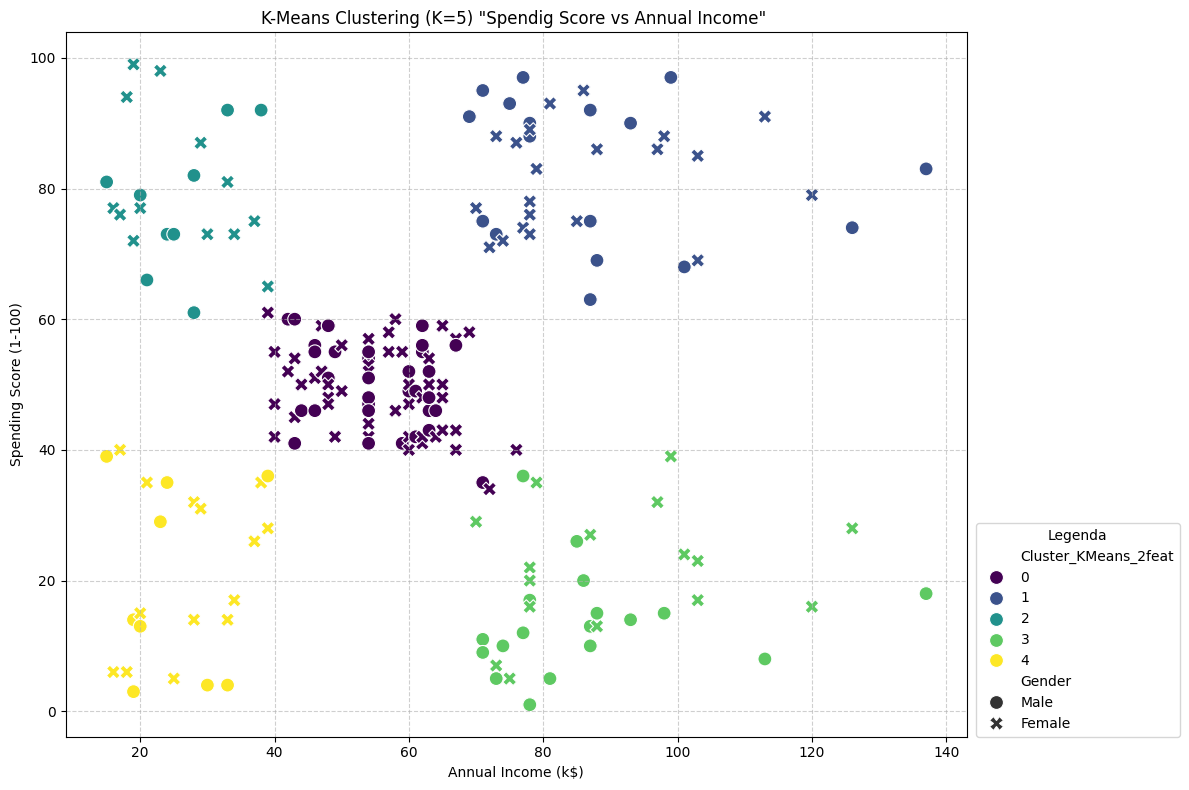

In [19]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init='auto', random_state=42)
labels_kmeans = kmeans.fit_predict(X_IncomeSpending_all)
df['Cluster_KMeans_2feat'] = labels_kmeans
total_population = len(df)
# View the Statistical Table with Percentage Data
stats_kmeans_2D = df.groupby('Cluster_KMeans_2feat').agg(
    Cluster_Size=('Cluster_KMeans_2feat', 'size'),
    Average_Income=('Annual Income (k$)', 'mean'),
    Average_Spending_Score=('Spending Score (1-100)', 'mean'),
    Average_Age=('Age', 'mean'),
    # Male and Female count
    Male_Count=('Gender', lambda x: (x == 'Male').sum()),
    Female_Count=('Gender', lambda x: (x == 'Female').sum())
).reset_index()
# Percentage evaluation
stats_kmeans_2D['Population_%'] = (stats_kmeans_2D['Cluster_Size'] / total_population) * 100
stats_kmeans_2D['Male_%'] = (stats_kmeans_2D['Male_Count'] / stats_kmeans_2D['Cluster_Size']) * 100
stats_kmeans_2D['Female_%'] = (stats_kmeans_2D['Female_Count'] / stats_kmeans_2D['Cluster_Size']) * 100
# Select the columns
stats_final = stats_kmeans_2D[['Cluster_KMeans_2feat', 'Population_%','Average_Income', 'Average_Spending_Score','Average_Age', 'Male_%', 'Female_%']]
# View final table
display(stats_final.style.hide(axis='index').set_caption("K-Means (K=5) Cluster Statistics (Percentages)").format
        ({'Population_%': "{:.1f}%", 'Average_Income': "{:.1f}", 'Average_Spending_Score': "{:.1f}", 'Average_Age': "{:.1f}",
           'Male_%': "{:.1f}%", 'Female_%': "{:.1f}%"}))
# Scatter Plot 
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_KMeans_2feat', data=df, palette='viridis', style='Gender', s=100)
plt.title('K-Means Clustering (K=5) "Spendig Score vs Annual Income" ')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True, linestyle='--', alpha=0.6)
# legend
plt.legend(title='Legenda', loc='lower left', bbox_to_anchor=(1.01, 0), borderaxespad=0)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

**"Low-Income Groups" (Clusters 2 & 4)**  
These segments represent customers with limited annual income but opposite spending habits:

- **Cluster 2 - "Young High Spenders"**: High spending score and the youngest average age.
- **Cluster 4 - "Mature Low Spenders"**: Lowest spending score and mature age. 

**"High-Income Groups" (Clusters 1 & 3)**  
These are customers with the highest annual income:

- **Cluster 1 - "Luxury Enthusiasts"**: Extremely high spending (82.1) and relatively young (32.7).
- **Cluster 3 - "High Income Savers"**: High income but the lowest spending score (17.6). More mature (40.7) and selective. 

**"Balanced Cluster" (Cluster 0)**  
Represent the majority of the population (40.5%). Income (55.3k), spending (49.5), and age (42.7 years) values are close to the dataset's overall average. No extreme behaviors.  

For details, check out [Part 3](https://medium.com/towards-artificial-intelligence/from-math-to-marketing-validating-clusters-and-extracting-actionable-insights-264d4443ee3b) of my series on Towards AI


#### Clustering and Interpretation of Results: "Age", "Annual Income" and "Spendig Score" features - KMeans with K=6


Cluster_KMeans_3feat,Population_%,Average_Income,Average_Spending_Score,Average_Age,Male_%,Female_%
0,22.5%,54.3,49.1,56.3,42.2%,57.8%
1,19.5%,86.5,82.1,32.7,46.2%,53.8%
2,12.5%,26.5,76.2,25.6,44.0%,56.0%
3,20.0%,59.4,44.5,26.1,40.0%,60.0%
4,15.0%,90.1,17.9,44.0,53.3%,46.7%
5,10.5%,26.3,19.4,45.5,38.1%,61.9%


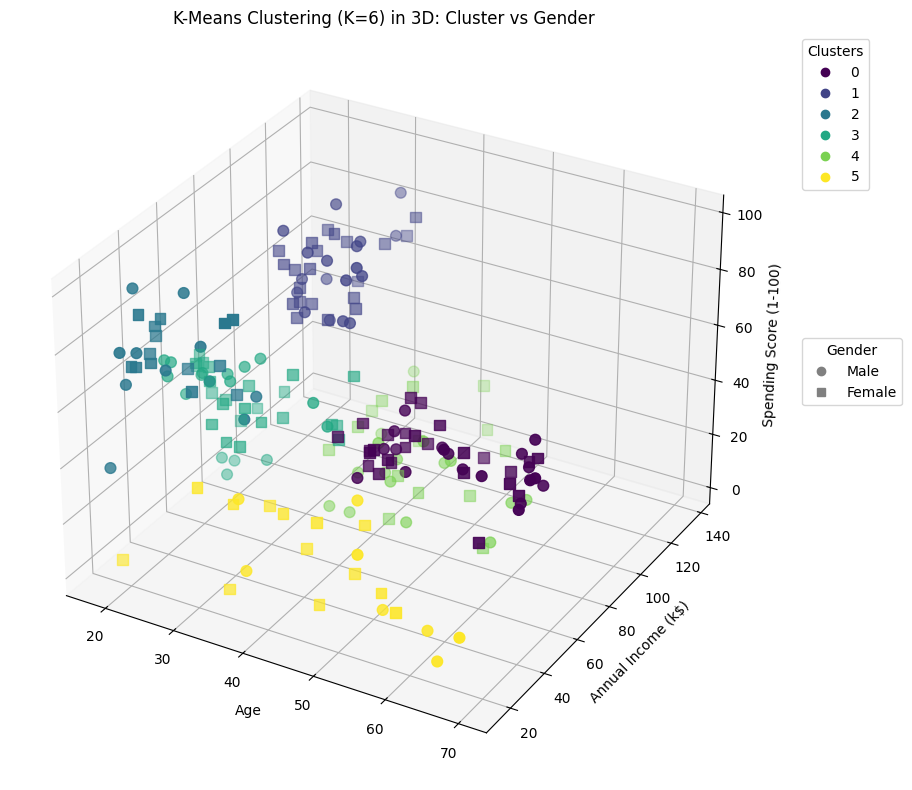

In [20]:
K = 6
kmeans = KMeans(n_clusters=K, init='k-means++', n_init='auto', random_state=42)
labels_kmeans = kmeans.fit_predict(X_AgeIncomeSpending_all)
df['Cluster_KMeans_3feat'] = labels_kmeans
total_population = len(df) 
# View the Statistical Table with Percentage Data
stats_kmeans_3D = df.groupby('Cluster_KMeans_3feat').agg(
    Cluster_Size=('Cluster_KMeans_3feat', 'size'),
    Average_Income=('Annual Income (k$)', 'mean'),
    Average_Spending_Score=('Spending Score (1-100)', 'mean'),
    Average_Age=('Age', 'mean'),
    # Male and Female count
    Male_Count=('Gender', lambda x: (x == 'Male').sum()),
    Female_Count=('Gender', lambda x: (x == 'Female').sum())
).reset_index()
# Percentage evaluation
stats_kmeans_3D['Population_%'] = (stats_kmeans_3D['Cluster_Size'] / total_population) * 100
stats_kmeans_3D['Male_%'] = (stats_kmeans_3D['Male_Count'] / stats_kmeans_3D['Cluster_Size']) * 100
stats_kmeans_3D['Female_%'] = (stats_kmeans_3D['Female_Count'] / stats_kmeans_3D['Cluster_Size']) * 100
# Select the columns
stats_final = stats_kmeans_3D[['Cluster_KMeans_3feat','Population_%', 'Average_Income','Average_Spending_Score', 'Average_Age', 'Male_%', 'Female_%']]
# View final table
display(stats_final.style.hide(axis='index').set_caption(f"K-Means (K={K}) Cluster Statistics (Percentages)").format({
            'Population_%': "{:.1f}%", 'Average_Income': "{:.1f}", 'Average_Spending_Score': "{:.1f}", 'Average_Age': "{:.1f}",
            'Male_%': "{:.1f}%", 'Female_%': "{:.1f}%"}))
#Plot 3D
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111, projection='3d')
cmap = plt.colormaps.get_cmap('viridis') 
markers = {'Male': 'o', 'Female': 's'} # Different markers for gender
scatters = []
for gender_val, marker in markers.items():
    # Filter data (using numeric 0/1)
    df_gender = df[df['Gender'] == gender_val]
    if not df_gender.empty:
        scatter = ax.scatter(
            df_gender['Age'], df_gender['Annual Income (k$)'], df_gender['Spending Score (1-100)'], 
            c=df_gender['Cluster_KMeans_3feat'], cmap=cmap, marker=marker, s=60, label=gender_val, vmin=0, vmax=K-1) 
        scatters.append(scatter)
ax.set_title(f'K-Means Clustering (K={K}) in 3D: Cluster vs Gender')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
if scatters:
    legend1 = ax.legend(*scatters[0].legend_elements(), title="Clusters", loc='upper left', bbox_to_anchor=(1.05, 1.0))
    ax.add_artist(legend1)
# Gender Marker Legend
handles = [plt.Line2D([], [], marker='o', color='gray', linestyle='None', label='Male'),
           plt.Line2D([], [], marker='s', color='gray', linestyle='None', label='Female')]
ax.legend(handles=handles, title="Gender", loc='upper left', bbox_to_anchor=(1.05, 0.6))
plt.tight_layout()
plt.show()

**3D Cluster Analysis: The Impact of Age**  
The 3D model ($K=6$) refines the previously monolithic "Balanced Cluster" (2D), splitting it into two generation-specific segments:
**Cluster 0 - "Senior Traditionalists":**   
Mature customers (avg. age 56.3) with a majority female (57.8%) profile and Average income/spending; likely the most loyal but least impulsive.    
**Cluster 3 - "Junior Pragmatists":**   
Very young (avg. age 26.1), predominantly female (60%)  

For details, check out [Part 3](https://medium.com/towards-artificial-intelligence/from-math-to-marketing-validating-clusters-and-extracting-actionable-insights-264d4443ee3b) of my series on Towards AI


#### References  
**Outlier:**  
https://online.stat.psu.edu/stat200/lesson/3/3.2  
https://www.geeksforgeeks.org/data-science/detect-and-remove-the-outliers-using-python/  
https://towardsdatascience.com/creating-boxplots-with-the-seaborn-python-library-f0c20f09bd57/  
**Mutual Information:**   
https://en.wikipedia.org/wiki/Mutual_information  
https://www.kaggle.com/code/ryanholbrook/mutual-information  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html  
**Scaling:**   
https://towardsdatascience.com/scaling-numerical-data-explained-a-visual-guide-with-code-examples-for-beginners-11676cdb45cb/  
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html  
**KMEANS**  
https://scikit-learn.org/stable/modules/clustering.html#k-means  
https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a/  
**Agglomerative Clustering**  
https://python.plainenglish.io/clustering-101-mastering-agglomerative-hierarchical-clustering-18752b7f4e6d  
**GMM**  
https://towardsdatascience.com/gaussian-mixture-models-for-clustering-3f62d0da675/  
https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html  
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  
**Validation Index**  
https://www.geeksforgeeks.org/machine-learning/what-is-silhouette-score/  
https://towardsdatascience.com/calinski-harabasz-index-for-k-means-clustering-evaluation-using-python-4fefeeb2988e/  
https://towardsdatascience.com/davies-bouldin-index-for-k-means-clustering-evaluation-in-python-57f66da15cd/